In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import os
from os.path import splitext, split
import sys
sys.path.insert(0,'../fibermetric')
from fibermetric import utils, histology

import nibabel as nib
import matplotlib.pyplot as plt
from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage
import numpy as np
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table
import time

# # from cloudvolume import CloudVolume

# # vol = CloudVolume(
# #     "s3://open-neurodata/kutten/Control189/Grayscale", mip=0, use_https=True
# # )

# # # load data into numpy array
# # cutout = vol[10752:11264, 13312:13824, 704:720]

# # # save cutout as TIFF
# # tifffile.imwrite("data.tiff", data=np.transpose(cutout))


ModuleNotFoundError: No module named 'fibermetric'

# define some useful functions

In [62]:
def polar_to_xyz(theta, phi, r=1):
    z = r * np.cos(theta)
    xy_hyp = r * np.sin(theta)
    y = xy_hyp * np.sin(phi)
    x = xy_hyp * np.cos(phi)
    
    return x, y, z


# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm)#, radial_scale=scale)
    if rot:
        sf_actor.RotateX(90)
    scene.add(sf_actor)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
#         sf_actor.RotateX(theta_step)
#         sf_actor.RotateY(theta_step)
        sf_actor.RotateZ(theta_step)

        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile


# Set up example measurement

In [63]:
rng = np.random.default_rng(1)

mu = 0
kappa = 5
size = 2**10

theta = rng.vonmises(mu, kappa, size=size)/2 + np.pi/2
theta_flip = np.pi - theta
theta = np.concatenate((theta, theta_flip))
phi = rng.vonmises(mu, kappa=0, size=size)
phi_flip = np.where(phi < 0, phi + np.pi, phi - np.pi)
phi = np.concatenate((phi, phi_flip))

polar = np.stack((theta,phi), -1)
print(f'polar shape: {polar.shape}')

polar shape: (2048, 2)


In [64]:
xyz = np.array(polar_to_xyz(polar[...,0], polar[...,1])).transpose()
print(f'xyz shape: {xyz.shape}')

xyz shape: (2048, 3)


# Set up histogram bin points

iterations: 35
time: 0.04956984519958496
delta: 0.08628716724342667
potential: 14790.730781348626


<IPython.core.display.Javascript object>


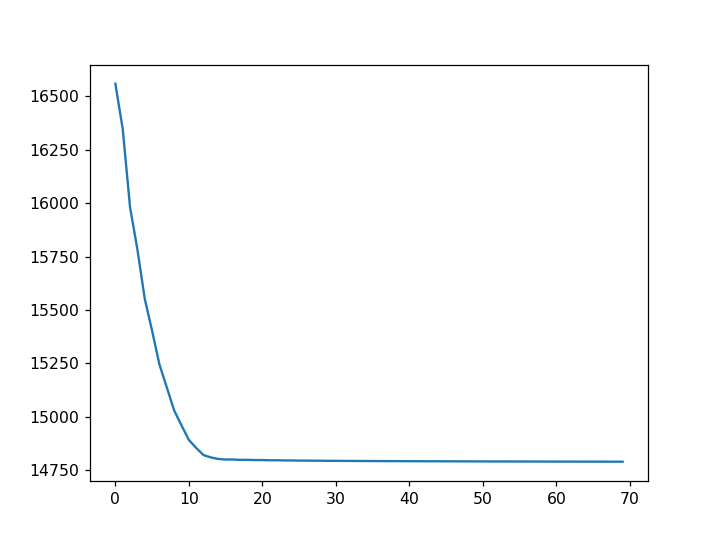

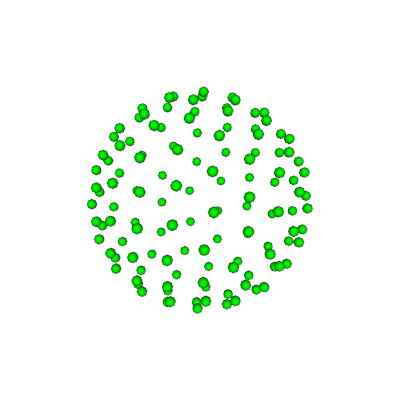

In [65]:
n_pts = 64
bvalue = 1000
np.random.seed(0)
theta = np.pi*np.random.rand(n_pts)
phi = 2 * np.pi*np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

it = 1
start = time.time()
hsph_updated, potential = disperse_charges(hsph_initial,2)#, const=0.5)
while np.abs(potential[-2]-potential[-1]) > 0.1:
    hsph_updated, pot = disperse_charges(hsph_updated,2)#, const=0.5)
    potential = np.append(potential,pot)
    it += 1
stop = time.time()
print(f"iterations: {it}")
print(f"time: {stop-start}")
print(f"delta: {np.abs(potential[-2]-potential[-1])}")
print(f"potential: {potential[-1]}")

plt.figure()
plt.plot(potential)

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])
bvecs = np.vstack((vertices))
bvals = np.hstack((bvalue * values))
# add some b=0 bvals/bvecs
bvecs = np.insert(bvecs, (0,bvecs.shape[0]), np.array([0,0,0]), axis = 0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

image = screenshot_gradients(sph_gtab, title='Example directions')
Image(filename=image)

In [67]:
# fill in histogram
bins = sph_gtab.vertices
hist = np.zeros(len(bins))
start = time.time()
for v in xyz: # find angles between one vector and every vertex 
    dist = np.arccos(np.dot(vertices,v))
    v_idx = np.argmax(np.abs(np.pi/2 - dist)) # find the vertex closest to the vector or the vector +- pi
    hist[v_idx] += 1
    hist[v_idx+len(vertices)] += 1
stop = time.time()
print(f'time elapsed: {stop-start}')

time elapsed: 0.017029285430908203


In [68]:
I.shape

(256, 2048, 3)

In [69]:
I = np.zeros((256,len(xyz),3))
I[:] = xyz

In [70]:
bins = sph_gtab.vertices
signal = np.zeros((len(I), len(bins)))
start = time.time()
for v in I[:]:
    dist = np.arccos(np.dot(vertices,v.T))
    v_idx = np.argmax(np.abs(np.pi/2 - dist), axis=0)
    signal[:,v_idx] += 1
    signal[:,v_idx+len(vertices)] += 1
stop = time.time()
print(f'time elapsed: {stop-start}')

time elapsed: 1.6444313526153564


In [71]:
signal.shape

(256, 128)

<IPython.core.display.Javascript object>


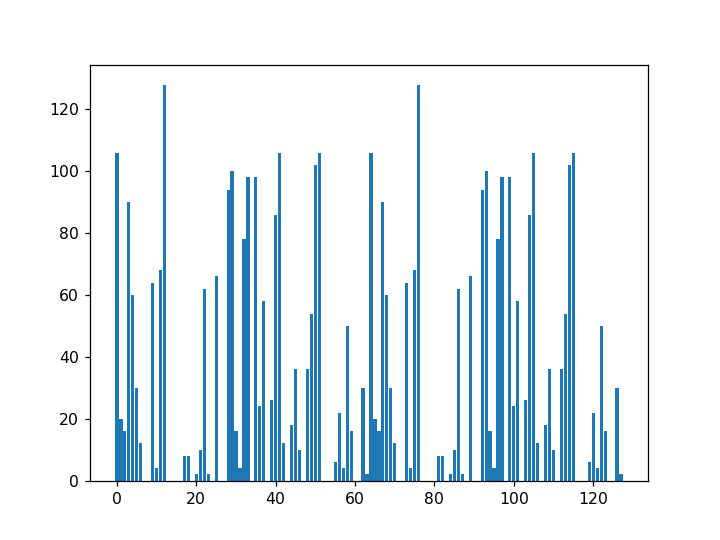

<BarContainer object of 128 artists>

In [72]:
plt.figure()
plt.bar(np.arange(len(hist)),hist)

In [73]:
from dipy.reconst.shm import sh_to_sf_matrix, sh_to_sf
from dipy.data import get_sphere

print('Building SH matrix of order 8')
B, invB = sh_to_sf_matrix(sph_gtab, 8)
print('Shape,', B.shape, '\n')

print('Building high resolution SH matrix of order 8')
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)
B_highres, invB_highres = sh_to_sf_matrix(sphere, 8)
print('Shape: ', B_highres.shape)

Building SH matrix of order 8
Shape, (45, 128) 

Building high resolution SH matrix of order 8
Shape:  (45, 11554)


In [74]:
sh_signal = sh_signal.reshape(16,16,45)

In [75]:
print('Estimate SH coefficients of the signal')
# S = B*sh_signal => sh_signal = invB * S
# sh_signal = np.dot(invB.T, hist)
sh_signal = np.dot(signal, invB)
print('SH signal shape, ', sh_signal.shape, '\n')
# print('Project back SH coefficient to the high resolution sphere')
# signal_sphere = np.dot(sh_signal, B_highres)
# # signal_sphere = np.dot(sh_signal.T, B_highres)
# print('SF signal shape: ', signal_sphere.shape)

Estimate SH coefficients of the signal
SH signal shape,  (256, 45) 



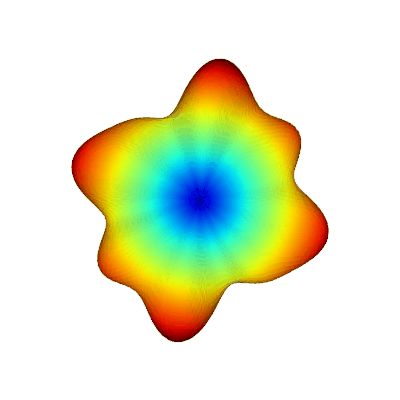

In [76]:
image = screenshot_animated_sf(signal_sphere, sphere, title='multi-tensor odf signal', theta_step=360, rot=False)

Image(filename=image)

In [9]:
root = '/home/brysongray/shattuck/RodentToolsData/OpticallyClearedSpinalCords/nii2/EAE32_F1LC_Sp10x/'
s0_path = 'TileScan_001_s0.nii.gz'

s0_nii = nib.load(os.path.join(root,s0_path))
affine = s0_nii.affine
header = s0_nii.header
print(affine)
print(header)

[[ 0.89099997  0.          0.          0.        ]
 [ 0.          0.89099997  0.          0.        ]
 [ 0.          0.         11.02000046  0.        ]
 [ 0.          0.          0.          1.        ]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   3 1024 1024   53    1    0    0    0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file    

In [3]:
print(header['descrip'])

b''


In [34]:
S = histology_tools.structure_tensor(s0, 1, dI=(0.891,0.891,11.02))
w,v = np.linalg.eigh(S)
w = w.astype('float32')[..., ::-1]
v = v.astype('float32')[..., :, ::-1]

In [39]:
w,v = np.linalg.eigh(S)
w = w.astype('float32')[..., ::-1]
v = v.astype('float32')[..., :, ::-1]
S_eig = np.stack((v[...,0,0], v[...,0,1], v[...,0,2], v[...,1,0], v[...,1,1], v[...,1,2],
             v[...,2,0], v[...,2,1], v[...,2,2], w[...,0], w[...,1], w[...,2]), axis=-1)
print(f"S_eig.dtype: {S_eig.dtype}")
print(f"S_eig.shape: {S_eig.shape}")
img = nib.Nifti1Image(S_eig, affine, new_header)
print(f"img.dtype: {np.asanyarray(img.dataobj).dtype}")
print(f"img.shape: {np.asanyarray(img.dataobj).shape}")

e00
(1024, 1024, 53)
float32
e01
(1024, 1024, 53)
float32
e02
(1024, 1024, 53)
float32
e10
(1024, 1024, 53)
float32
e11
(1024, 1024, 53)
float32
e12
(1024, 1024, 53)
float32
e20
(1024, 1024, 53)
float32
e21
(1024, 1024, 53)
float32
e22
(1024, 1024, 53)
float32
w0
(1024, 1024, 53)
float32
w1
(1024, 1024, 53)
float32
w2
(1024, 1024, 53)
float32


In [26]:
np.asarray(img.dataobj[512,512,26])

array([-1.9813021e-01, -5.6716913e-01,  7.9941452e-01, -4.6478796e-01,
        7.7242213e-01,  4.3282357e-01,  8.6296964e-01,  2.8580281e-01,
        4.1665354e-01,  2.5409877e+02,  8.0108955e+01,  1.2953174e+00],
      dtype=float32)

In [27]:
S_eig[512,512,26]

array([-1.9813021e-01, -5.6716913e-01,  7.9941452e-01, -4.6478796e-01,
        7.7242213e-01,  4.3282357e-01,  8.6296964e-01,  2.8580281e-01,
        4.1665354e-01,  2.5409877e+02,  8.0108955e+01,  1.2953174e+00],
      dtype=float32)

In [31]:
nib.save(img, 'test.nii')

In [33]:
test_eig_nii = nib.load('test.nii')
print(test_eig_nii.get_fdata()[512,512,26])
print(np.asarray(test_eig_nii.dataobj[512,512,26]).dtype)

[19738.77734375 19738.77734375 19738.77734375 19738.77734375
 19738.77734375 19738.77734375 19738.77734375 19738.77734375
 19738.77734375 19738.77734375 19738.77734375 19738.77734375]
float64


In [3]:
print(s0_nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   3 1024 1024   53    1    0    0    0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x     

In [10]:
new_header = s0_nii.header
# dim = np.array([4, 1024, 1024, 53, 12, 1, 1, 1], dtype='int16')
# new_header['dim'] = dim
new_header['datatype'] = 16
new_header['bitpix'] = 32
# new_header['glmax'] = 997
print(f"header: {new_header}")
print(f"affine: {s0_nii.affine}")

header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   3 1024 1024   53    1    0    0    0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0


In [12]:
out = '/home/brysongray/data/spinal_cords/structure_tensors/'
affine = s0_nii.affine
# header = s0_nii.header
for i,file in enumerate(sorted(os.listdir(root))):
    start = time.time()
    nii = nib.load(os.path.join(root,file))
    I = nii.get_fdata()
    S = histology.structure_tensor(I, 3, dI=(0.891,0.891,11.02))
    w,v = np.linalg.eigh(S)
    w = w.astype('float32')[..., ::-1]
    v = v.astype('float32')[..., :, ::-1]
    S_eig = {"v0_0":v[...,0,0], "v0_1":v[...,0,1], "v0_2":v[...,0,2], "v1_0":v[...,1,0], "v1_1":v[...,1,1], "v1_2":v[...,1,2],
         "v2_0":v[...,2,0], "v2_1":v[...,2,1], "v2_2":v[...,2,2], "w0":w[...,0], "w1":w[...,1], "w2":w[...,2]}
    for label,vol in S_eig.items():
        img = nib.Nifti1Image(vol, affine, new_header)
        fbase = splitext(splitext(file)[0])[0]
        new_fname = fbase + '.' + label + '.nii.gz'
        out_file = os.path.join(out, fbase, new_fname)
        if not os.path.exists(split(out_file)[0]):
            os.makedirs(split(out_file)[0])
        nib.save(img, out_file)
        print(f'saved {out_file}')
    stop = time.time()
    print(f"time elapsed: {stop-start}")
#     S_eig = np.stack((v[...,0,0], v[...,0,1], v[...,0,2], v[...,1,0], v[...,1,1], v[...,1,2],
#                  v[...,2,0], v[...,2,1], v[...,2,2], w[...,0], w[...,1], w[...,2]), axis=-1)
#     img = nib.Nifti1Image(S_eig, affine, new_header)
#     fname = os.path.splitext(os.path.splitext(file)[0])[0]
#     nib.save(img, os.path.join(out, fname + '_sta.eig.nii'))
#     print(fname+'_sta.eig.nii')

ValueError: operands could not be broadcast together with shapes (1024,1024,53,9) (1024,1024,53) 

In [ ]:
out = '/home/brysongray/data/spinal_cords/structure_tensors/'
affine = s0_nii.affine
# header = s0_nii.header
for i,file in enumerate(sorted(os.listdir(root))):
    nii = nib.load(os.path.join(root,file))
    I = nii.get_fdata()
    S = histology_tools.structure_tensor(I, 1, dI=(0.891,0.891,11.02))
    w,v = np.linalg.eigh(S)
    w = w.astype('float32')[..., ::-1]
    v = v.astype('float32')[..., :, ::-1]
    S_eig = np.stack((v[...,0,0], v[...,0,1], v[...,0,2], v[...,1,0], v[...,1,1], v[...,1,2],
                 v[...,2,0], v[...,2,1], v[...,2,2], w[...,0], w[...,1], w[...,2]), axis=-1)
    img = nib.Nifti1Image(S_eig, affine, new_header)
    fname = os.path.splitext(os.path.splitext(file)[0])[0]
    nib.save(img, os.path.join(out, fname + '_sta.eig.nii'))
    print(fname+'_sta.eig.nii')

TileScan_001_s0_sta.eig.nii
TileScan_001_s1_sta.eig.nii
TileScan_001_s2_sta.eig.nii
TileScan_001_s3_sta.eig.nii
TileScan_001_s4_sta.eig.nii
TileScan_001_s5_sta.eig.nii
TileScan_001_s6_sta.eig.nii
TileScan_001_s7_sta.eig.nii
TileScan_001_s8_sta.eig.nii


In [8]:
np.save('test_eig.npy', S_eig)

In [16]:
S_eig = np.load('test_eig.npy')
img = nib.Nifti1Image(S_eig, affine, new_header)
fname = os.path.splitext(os.path.splitext(file)[0])[0]
nib.save(img, os.path.join(out, fname + '_sta.eig.nii'))
print(fname+'_sta.eig.nii')

TileScan_001_s0_sta.eig.nii


In [2]:
s0_nii = nib.load('/home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s8/TileScan_001_s8.v0_0.nii.gz')
s0_sta = np.asarray(s0_nii.dataobj)

In [3]:
s0_sta.dtype

dtype('<f4')

In [4]:
s0_sta.shape

(1024, 1024, 53)

In [6]:
s0_sta[512,512,9].dtype

dtype('float32')

In [34]:
S[512,512,9]

array([[ 230.14927299, -104.90173169,  279.        ],
       [-104.90173169, 1000.83092751,   93.        ],
       [ 279.        ,   93.        ,  961.        ]])

In [9]:
test = nib.load("/home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.eig.nii.gz")
test_ = test.header

data code 0 not supported; not attempting fix


HeaderDataError: data code 0 not supported